# 06.4 - Common Operations II: Group By/Custom functions

Continuing directly from the previous notebook. Let's look into two other common operations for dataframes.

---
## groupby

A groupBy transformation will collect identical items from a single column or group of columns and will perform an aggregation according to the set of rules you decide. Let's look at an exemple so you can understand it better. We'll use the classic "Company Personnel sheet" dataset.

In [1]:
import dask.dataframe as dd

In [2]:
ddcs = dd.read_csv("../Files/Company_Personnel_Sheet.csv") ## Only have constructed the instruction

In [11]:
ddcs.head(10)

,employee_name,department,state,salary,age,bonus
0,James,Sales,NY,90000,34,10000
1,Michael,Sales,NY,86000,56,20000
2,Robert,Sales,CA,81000,30,23000
3,Maria,Finance,CA,90000,24,23000
4,Raman,Finance,CA,99000,40,24000
5,Scott,Finance,NY,83000,36,19000
6,Jen,Finance,NY,79000,53,15000
7,Jeff,Marketing,CA,80000,25,18000
8,Kumar,Marketing,NY,91000,50,21000


In [4]:
len(ddcs)

9

Let's say you want to know the total bonus for wach department. You __group__ the data __by__ the __department__ column and sum the __bonus__ column.

First, let's explore the object:

In [5]:
groupdf = ddcs.groupby("department")

In [7]:
groupdf

In [8]:
groupdf.sum()

,salary,age,bonus
npartitions=1,,,
,int64,int64,int64
,...,...,...


Both __groupby__ and __sum__ are methods that can be applied in succession. They will build upon the __DAG__ of instructions.

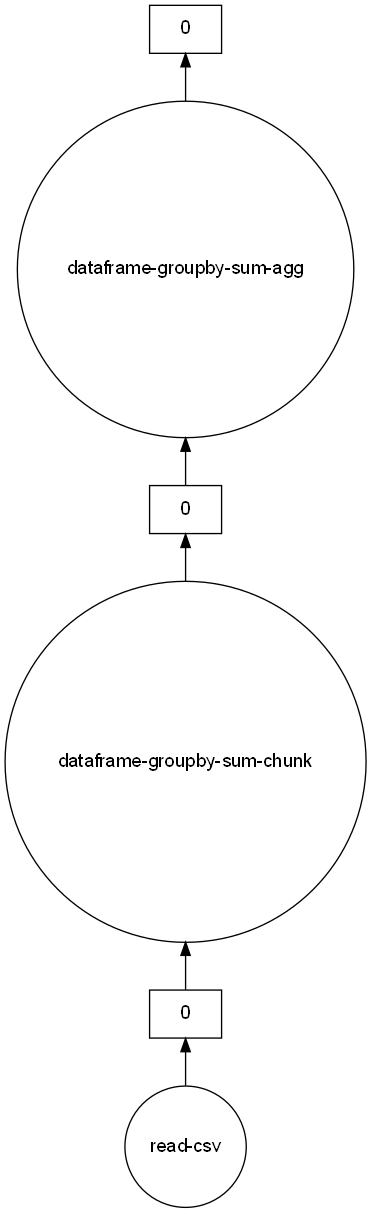

In [9]:
groupdf.sum().visualize()

Now, let's finally __compute__ all our instructions:

In [10]:
groupdf.sum().compute()

,salary,age,bonus
department,,,
Finance,351000,153,81000
Marketing,171000,75,39000
Sales,257000,120,53000


The aggreagtion found out all of our numerical values and applied the algorithm "sum" wherver it was possible!

Since we only want the __bonus__ section, it is faster to just select that column for the __groupby__ instead of calculating it for several columns and filtering at the end. Since we only have onw column, the return type defaults to a __Series__.

In [12]:
ddcs.groupby("department")["bonus"].sum().compute()

department
Finance      81000
Marketing    39000
Sales        53000
Name: bonus, dtype: int64

---

Now let's say you want to know how many employees each department has. Since each line is an entry for a different employee, we can just __count__ the number of lines after aggregation as the number of employees.

In [13]:
ddcs.groupby("department").count()

,employee_name,state,salary,age,bonus
npartitions=1,,,,,
,int64,int64,int64,int64,int64
,...,...,...,...,...


In [14]:
ddcs.groupby("department").count().compute()

,employee_name,state,salary,age,bonus
department,,,,,
Finance,4,4,4,4,4
Marketing,2,2,2,2,2
Sales,3,3,3,3,3


There are four elements from Finance, 2 from Marketing, and 3 from Sales.

You can go deeper: you can break it down by department and affiliate (in this case "state").

In [15]:
ddcs.groupby(["department", "state"]).count().compute()

employee_name  salary  age  bonus
department state                                   
Finance    CA                 2       2    2      2
           NY                 2       2    2      2
Marketing  CA                 1       1    1      1
           NY                 1       1    1      1
Sales      CA                 1       1    1      1
           NY                 2       2    2      2

There is a Marketing employee from CA and one from NY, as an example.

You can keep adding agregations as well. Let's say we want to also find out the maximum __Bonus__ for each department and state, the total bonus, and the average salary. To do so in a more explicit way, we use the __agg__ method.

Build a dictionary with the required functions andd pass it to __agg__, like in the example:

In [16]:
ddcs.groupby(["department", "state"]).agg({'bonus': ['max', 'sum'], 'salary': 'mean'})

Dask DataFrame Structure:
               bonus          salary
                 max    sum     mean
npartitions=1                       
               int64  int64  float64
                 ...    ...      ...
Dask Name: aggregate-agg, 3 tasks

In [17]:
ddcs.groupby(["department", "state"]).agg({'bonus': ['max', 'sum'], 'salary': 'mean'}).compute()

bonus          salary
                    max    sum     mean
department state                       
Finance    CA     24000  47000  94500.0
           NY     19000  34000  81000.0
Marketing  CA     18000  18000  80000.0
           NY     21000  21000  91000.0
Sales      CA     23000  23000  81000.0
           NY     20000  30000  88000.0

<div class="alert alert-info">
    <b> Exercise: group by "Department" and "State" and extract the following breakdown<b>
</div>

1. Number of employess according to the grouping
1. Maximum Bonus
1. Sum of all Bonuses
1. Average salary

In [35]:
# %load ../Files/Dask_GroupBy.txt

---

## User Defined Functions

Sometimes you may need a function that is not a python built in. You can define a python function and apply it.

Let's exemplify with an example.

In this example, we wish to extrapolate the total expenditure of the company for next year.

The company expects to __increase salaries by 5%__ and __increase the bonuses by 10%__.

In [36]:
import dask.dataframe as dd

ddcs = dd.read_csv("../Files/Company_Personnel_Sheet.csv")

Let's create a custom function:

In [37]:
def expenditure_nextyear(row, increase_salary=0.0, increase_bonus=0.0):
    """Extrapolates the expenditure for next year"""
    expenditure = row["salary"] * (1.0 + increase_salary) + row["bonus"] * (1.0 + increase_bonus)

    return expenditure

Let's recover the original dataframe.

In [38]:
ddcs["total_expenditure"] = ddcs.apply(expenditure_nextyear, args=(0.05, 0.1), axis=1)

C:\Users\luisg\anaconda3\envs\dask\lib\site-packages\dask\dataframe\core.py:5156: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))


In [39]:
ddcs.head()

,employee_name,department,state,salary,age,bonus,total_expenditure
0,James,Sales,NY,90000,34,10000,105500.0
1,Michael,Sales,NY,86000,56,20000,112300.0
2,Robert,Sales,CA,81000,30,23000,110350.0
3,Maria,Finance,CA,90000,24,23000,119800.0
4,Raman,Finance,CA,99000,40,24000,130350.0


When working with large datasets, be sure to specifiy the type of the variables in the columns. This avoids warnings or possible crashes. Since we are doing percentages, play it safe and use float64.

In [40]:
ddcs["total_expenditure"] = ddcs.apply(expenditure_nextyear, args=(0.05, 0.1), meta=('float64', 'float64'), axis=1)

In [42]:
ddcs.head(10)

,employee_name,department,state,salary,age,bonus,total_expenditure
0,James,Sales,NY,90000,34,10000,105500.0
1,Michael,Sales,NY,86000,56,20000,112300.0
2,Robert,Sales,CA,81000,30,23000,110350.0
3,Maria,Finance,CA,90000,24,23000,119800.0
4,Raman,Finance,CA,99000,40,24000,130350.0
5,Scott,Finance,NY,83000,36,19000,108050.0
6,Jen,Finance,NY,79000,53,15000,99450.0
7,Jeff,Marketing,CA,80000,25,18000,103800.0
8,Kumar,Marketing,NY,91000,50,21000,118650.0


---
## Example of a sequence of transformations

Imagine this dataset is actually larger than your laptop's memory.

Or company has an office in the capital of each state. We were requested to make a report to send to the capital of each state to figure out the total expenditure planned for next year.

The best way to parallelize the procedure is to make all transformations in one go and then, finally output them to a file.

Let's open the personnel sheet and the catalog for state capitals, so we can know which city we have to send the value to.

In [43]:
import dask.dataframe as dd

ddcs = dd.read_csv("../Files/Company_Personnel_Sheet.csv")
ddcs.head()

,employee_name,department,state,salary,age,bonus
0,James,Sales,NY,90000,34,10000
1,Michael,Sales,NY,86000,56,20000
2,Robert,Sales,CA,81000,30,23000
3,Maria,Finance,CA,90000,24,23000
4,Raman,Finance,CA,99000,40,24000


In [44]:
ddcap = dd.read_csv("../Files/USA_States.txt")
ddcap.head()

,Full name,Standard abbreviation,Postal abbreviation,Capital city
0,Alabama,Ala.,AL,Montgomery
1,Alaska,Alaska,AK,Juneau
2,Arizona,Ariz.,AZ,Phoenix
3,Arkansas,Ark.,AR,Little Rock
4,California,Calif.,CA,Sacramento


<div class="alert alert-info">
    <b> Question: What is best?<b>
</div>
        
1. First do the join and then the groupby?
1. First do the groupby and then the join?

In [45]:
def expenditure_nextyear(row, increase_salary=0.0, increase_bonus=0.0):
    """Extrapolates the expenditure for next year"""
    expenditure = row["salary"] * (1.0 + increase_salary) + row["bonus"] * (1.0 + increase_bonus)

    return expenditure

In [46]:
ddcs["total_expenditure"] = ddcs.apply(expenditure_nextyear, args=(0.05, 0.1), meta=('float64', 'float64'), axis=1)

In [47]:
gdd = ddcs.groupby("state")["total_expenditure"].sum()

In [48]:
gdd

Dask Series Structure:
npartitions=1
    float64
        ...
Name: total_expenditure, dtype: float64
Dask Name: series-groupby-sum-agg, 5 tasks

<div class="alert alert-danger">
    <b> Uh Oh! gdd is a series! And it has no merge method!<b>
</div>

In [51]:
gdd = ddcs.groupby("state")["total_expenditure"].sum().to_frame()

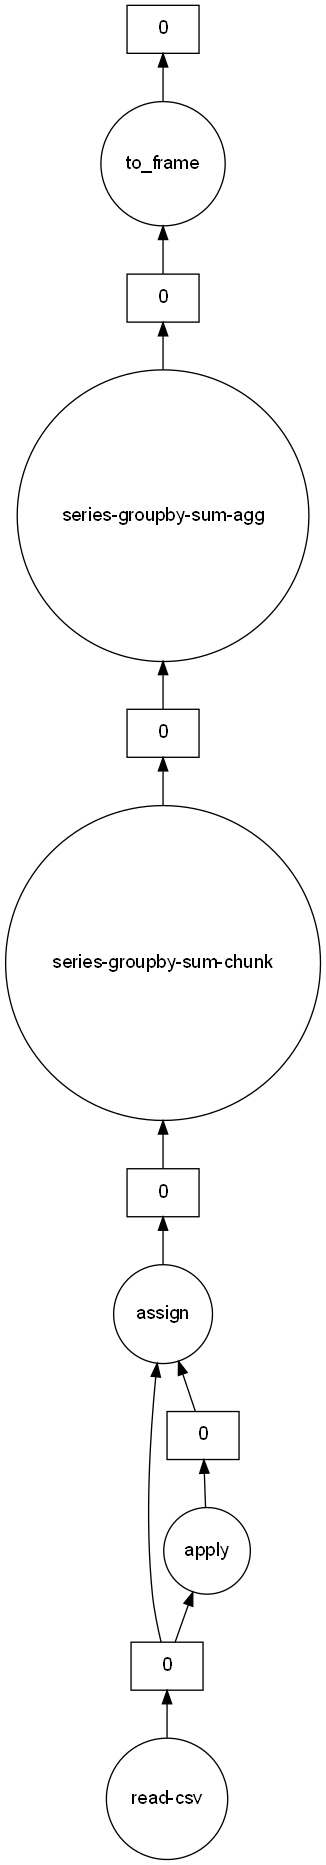

In [52]:
gdd.visualize()

In [53]:
gdp = gdd.merge(ddcap, left_on="state", right_on="Postal abbreviation")

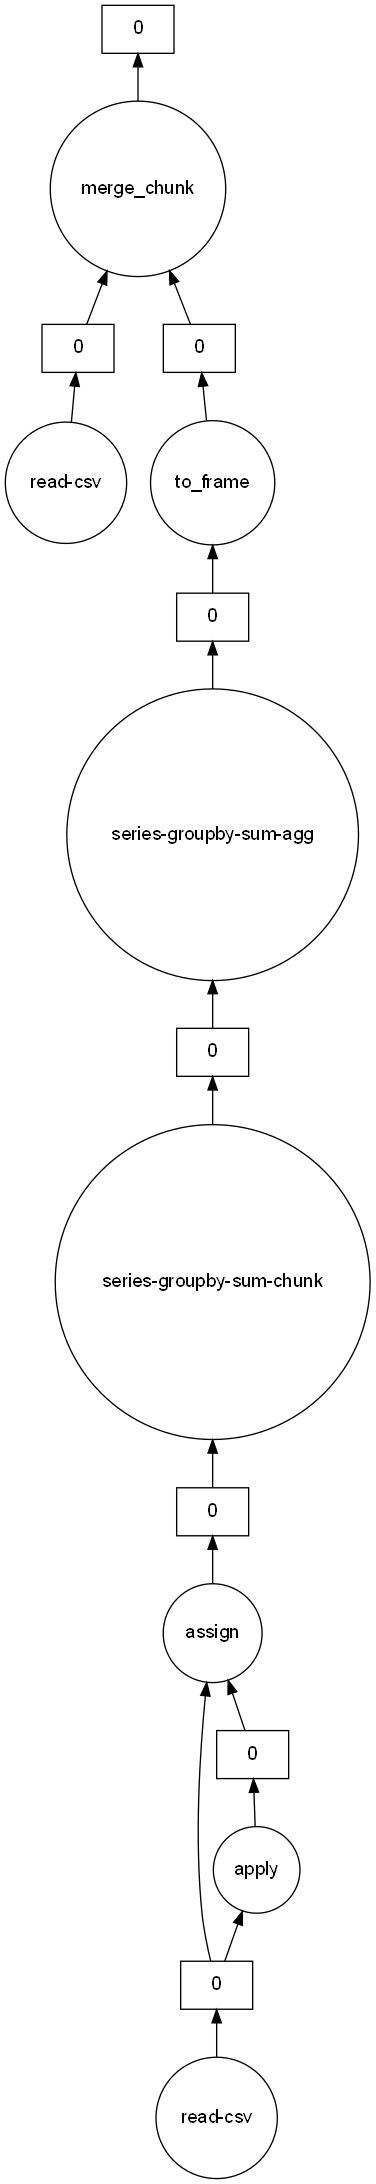

In [54]:
gdp.visualize()

<div class="alert alert-success">
    <b> Finally! We do everything in one step.<b>
</div>

In [55]:
gdp.compute()

,total_expenditure,Full name,Standard abbreviation,Postal abbreviation,Capital city
0,464300.0,California,Calif.,CA,Sacramento
1,543950.0,New York,N.Y.,NY,Albany


---
[Let's take a look at a pipeline with a large dataset.](06.5-Pipeline.ipynb)